In [48]:
# pip install
!pip install -r requirements.txt
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(['science','no-latex'])
from matplotlib import ticker
import numpy as np
import pandas as pd
from pprint import pprint

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


In [49]:
# Open data file
physics_model = "NC"
file_dir = f"./assets/{physics_model}/A_Z_vol_count-all.txt"
columns = ["Mass Number", "Atomic Number", "Detector Volume", "Counts"]
df = open_data(file_dir, columns)

In [50]:
# Add in isotope data
add_isotope_data(df)
# Reorder columns
df = df[["Iso Symbol","Atomic Number","Mass Number","Counts", "Detector Volume","Production Yield","Stable","Half Life (ns)","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]

# Add Production (/yr)

In [51]:
# Simulation length = years * nanoseconds
year_in_nano = (3.154 * 10**16)
year_in_sec = (3.154 * 10**7)
sim_length = 29.01
df["Production (/yr)"] = df["Counts"] / sim_length

# Add count per muon

In [52]:
# number of muons per year
muon_no = (3.447 * 10**6)
df["Count per Muon"] = df["Production (/yr)"] / muon_no
# Normalise
df["Count per Muon"] = (df["Count per Muon"] - df["Count per Muon"].min()) / (df["Count per Muon"].max() - df["Count per Muon"].min())

# Clean unstable isotopes into two datasets

In [53]:
df_unstable = df[df["Stable"] == False]
df_unstable = df_unstable.reset_index()
df_stable = df[df["Stable"] == True]
df_stable = df_stable.reset_index()
print(f"Number of stable isotopes: {len(df) - len(df_unstable)}")
print(f"Number of unstable isotopes: {len(df_unstable)}")
#df_unstable, df_stable

Number of stable isotopes: 127
Number of unstable isotopes: 399


In [54]:
# Data analysis
print(f"Total average production yield per muon: {round(df['Count per Muon'].mean(), 5)}")
print(f"Unstable average production yield per muon: {round(df_unstable['Count per Muon'].mean(), 5)}")
print(f"Stable average production yield per muon: {round(df_stable['Count per Muon'].mean(), 5)}")

Total average production yield per muon: 0.00478
Unstable average production yield per muon: 0.00024
Stable average production yield per muon: 0.01907


# Plot All

185


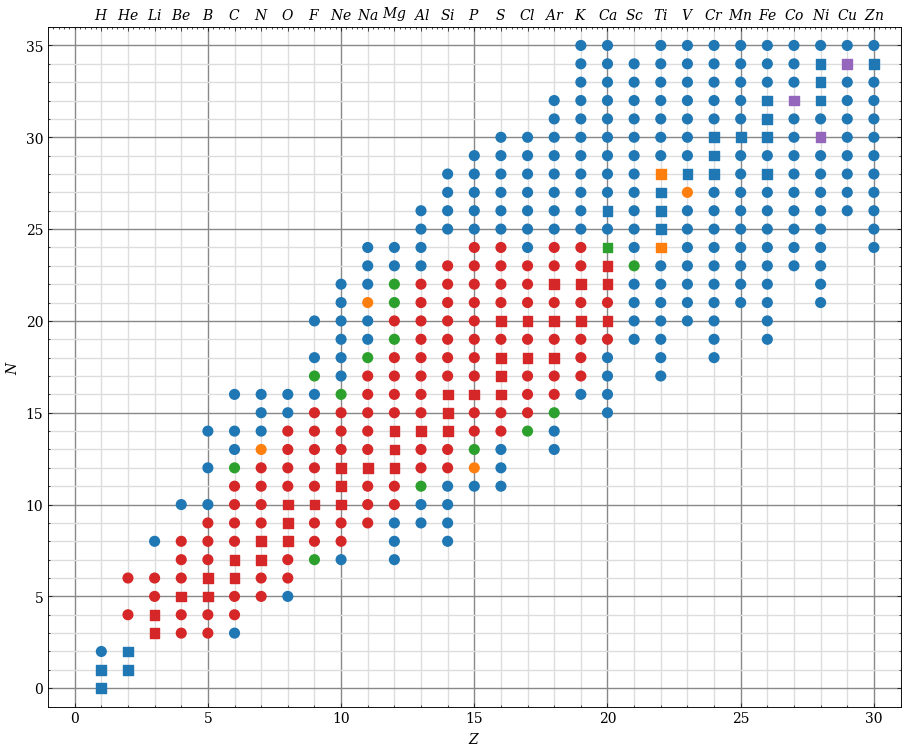

In [77]:
PTS_PER_INCH = 72

df_plot = df

element_symbols = [
 'H', 'He', 'Li', 'Be',  'B',  'C',  'N',  'O',  'F', 'Ne', 'Na', 'Mg', 'Al',
'Si',  'P',  'S', 'Cl', 'Ar',  'K', 'Ca', 'Sc', 'Ti',  'V', 'Cr', 'Mn', 'Fe',
'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',  'Y',
'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',  'W', 'Re', 'Os', 'Ir', 'Pt',
'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa',
 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf',
'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts',
'Og'
]

def get_marker_size(ax, nx, ny):
    """Determine the appropriate marker size (in points-squared) for ax."""
    # Get Axes width and height in pixels.
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    # Spacing between scatter point centres along the narrowest dimension.
    spacing = min(width, height) * PTS_PER_INCH / min(nx, ny)
    # Desired radius of scatter points.
    rref =  spacing / 2 * 0.5
    # Initial scatter point size (area) in pt^2.
    s = np.pi * rref**2
    return s

det_count = 0
isotopes_stable = {}
isotopes_unstable = {}
for line in open('isotopes.txt'):
    line = line.rstrip()
    halflife = line[10:]
    if halflife == 'None':
        continue
    fields = line[:10].split('-')
    symbol = fields[0]
    A = int(fields[1].split()[0])
    Z = int(element_symbols.index(symbol)) + 1
    N = A - Z
    halflife = float(halflife)
    if Z < 31 and N < 36:
        checkTPC = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & (df_plot["Detector Volume"] == 11)]
        checkBUFFERS = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & ((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9))]
        checkELSE = df_plot[(df_plot["Mass Number"] == A) & (df_plot["Atomic Number"] == Z) & ~((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9) | (df_plot["Detector Volume"] == 11))]
        det_count += 1
        # if stable
        if halflife >= 0:
            # if in both - red
            if not checkTPC.empty and not checkBUFFERS.empty:
                isotopes_stable[(N, Z)] = np.array([214, 39, 40]) / 255
            # If in TPC - orange
            elif not checkTPC.empty:
                isotopes_stable[(N, Z)] = np.array([255, 127, 14]) / 255
            # If in buffers - green
            elif not checkBUFFERS.empty:
                isotopes_stable[(N, Z)] = np.array([44, 160, 44]) / 255
            # If in elsewhere - purple
            elif not checkELSE.empty:
                isotopes_unstable[(N, Z)] = np.array([148, 103, 189]) / 255
            # Else blue
            else:
                isotopes_stable[(N, Z)] = np.array([31, 119, 180]) / 255
                det_count -= 1
        # if unstable
        else:
            # if in both - red
            if not checkTPC.empty and not checkBUFFERS.empty:
                isotopes_unstable[(N, Z)] = np.array([214, 39, 40]) / 255
            # If in TPC - orange
            elif not checkTPC.empty:
                isotopes_unstable[(N, Z)] = np.array([255, 127, 14]) / 255
             # If in buffers - green
            elif not checkBUFFERS.empty:
                isotopes_unstable[(N, Z)] = np.array([44, 160, 44]) / 255
            # If in elsewhere - purple
            elif not checkELSE.empty:
                isotopes_unstable[(N, Z)] = np.array([148, 103, 189]) / 255
            # Else blue
            else:
                isotopes_unstable[(N, Z)] = np.array([31, 119, 180]) / 255
                det_count -= 1
print(det_count)

k_s, colors_s = zip(*isotopes_stable.items())
N_s, Z_s = zip(*k_s)
k_u, colors_u = zip(*isotopes_unstable.items())
N_u, Z_u = zip(*k_u)
maxN, maxZ = max(max(N_s), max(N_u)) + 1, max(max(Z_s), max(Z_u)) + 1

# Initial dimensions of the plot
w, h = 1100, 900
DPI_nuc = 100
w_in, h_in = w / DPI_nuc, h / DPI_nuc

fig, ax = plt.subplots(figsize=(w_in, h_in), dpi=DPI_nuc)

s = get_marker_size(ax, maxZ, maxN)
sc1 = ax.scatter(Z_s, N_s, c=colors_s, s=s, marker="o")
sc1 = ax.scatter(Z_u, N_u, c=colors_u, s=s, marker="s")

# Grid on both major and minor ticks
loc = ticker.MultipleLocator(base=5)
ax.xaxis.set_minor_locator(loc)
ax.yaxis.set_minor_locator(loc)
ax.grid(which='major', color='#888888', lw=1)
ax.grid(which='minor', color='#dddddd', lw=1)
plt.minorticks_on()
ax.set_axisbelow(True)

ax.set_xlim(-1, maxZ)
ax.set_ylim(-1, maxN)
ax.set_xlabel(r'$Z$')
ax.set_ylabel(r'$N$')
# Noble gas elements on the top x-axis.
topax = ax.twiny()
top_axis = [r'$H$', r'$He$', r'$Li$', r'$Be$',  r'$B$',  r'$C$',  r'$N$',  r'$O$',  r'$F$', r'$Ne$', r'$Na$', r'$Mg$', r'$Al$',
r'$Si$',  r'$P$',  r'$S$', r'$Cl$', r'$Ar$',  r'$K$', r'$Ca$', r'$Sc$', r'$Ti$',  r'$V$', r'$Cr$', r'$Mn$',r'$Fe$',r'$Co$', r'$Ni$', r'$Cu$', r'$Zn$']
topax.set_xticks(np.linspace(1, len(top_axis), len(top_axis)))
topax.set_xticklabels(top_axis)
topax.set_xlim(-1, maxZ)
plt.savefig('./img/nuclides-chart.png', dpi=DPI_nuc)
plt.show()
# Need to get legend https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html#automated-legend-creation
other_volumes_df = df_plot[~((df_plot["Detector Volume"] == 7) | (df_plot["Detector Volume"] == 9) | (df_plot["Detector Volume"] == 11))]

In [78]:
other_volumes_df

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
21,Li 3-6,3,6,4,6,1.384705e-08,True,inf,None,NaN,blue,0.137883,2.61295e-08
79,B 5-11,5,11,1,10,3.461762e-09,True,inf,None,NaN,blue,0.0344709,0
91,C 6-12,6,12,46,8,1.592411e-07,True,inf,None,NaN,blue,1.58566,3.91943e-07
93,C 6-12,6,12,33,10,1.142382e-07,True,inf,None,NaN,blue,1.13754,2.78715e-07
103,C 6-13,6,13,1,8,3.461762e-09,True,inf,None,NaN,blue,0.0344709,0
138,O 8-16,8,16,26,10,9.000582e-08,True,inf,None,NaN,blue,0.896243,2.17746e-07
524,Co 27-59,27,59,3,6,1.038529e-08,True,inf,None,NaN,blue,0.103413,1.74197e-08
523,Ni 28-58,28,58,1,6,3.461762e-09,True,inf,None,NaN,blue,0.0344709,0
525,Cu 29-63,29,63,57,6,1.973204e-07,True,inf,None,NaN,blue,1.96484,4.87751e-07


In [57]:
# Plot total
figsize=(20,40)
# Plotting
fig, ax = plt.subplots(figsize=figsize)
ax.barh(df.index, df["Production Yield"], log=True, color=df["Plot Colour"])
ax.set_yticklabels(df["Iso Symbol"])
ax.set_yticks(np.arange(len(df)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax.set_title("All Isotopes")
red_patch = mpatches.Patch(color="red", label="Unstable")
blue_patch = mpatches.Patch(color="blue", label="Stable")
ax.legend(handles=[red_patch, blue_patch], loc=0)
#plt.show()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000134F6ADACA8> (for post_execute):


RuntimeError: Locator attempting to generate 2893 ticks from -26.6 to 551.7999999999979: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 2893 ticks from -26.6 to 551.7999999999979: exceeds Locator.MAXTICKS

<Figure size 1440x2880 with 1 Axes>

# Plot unstable

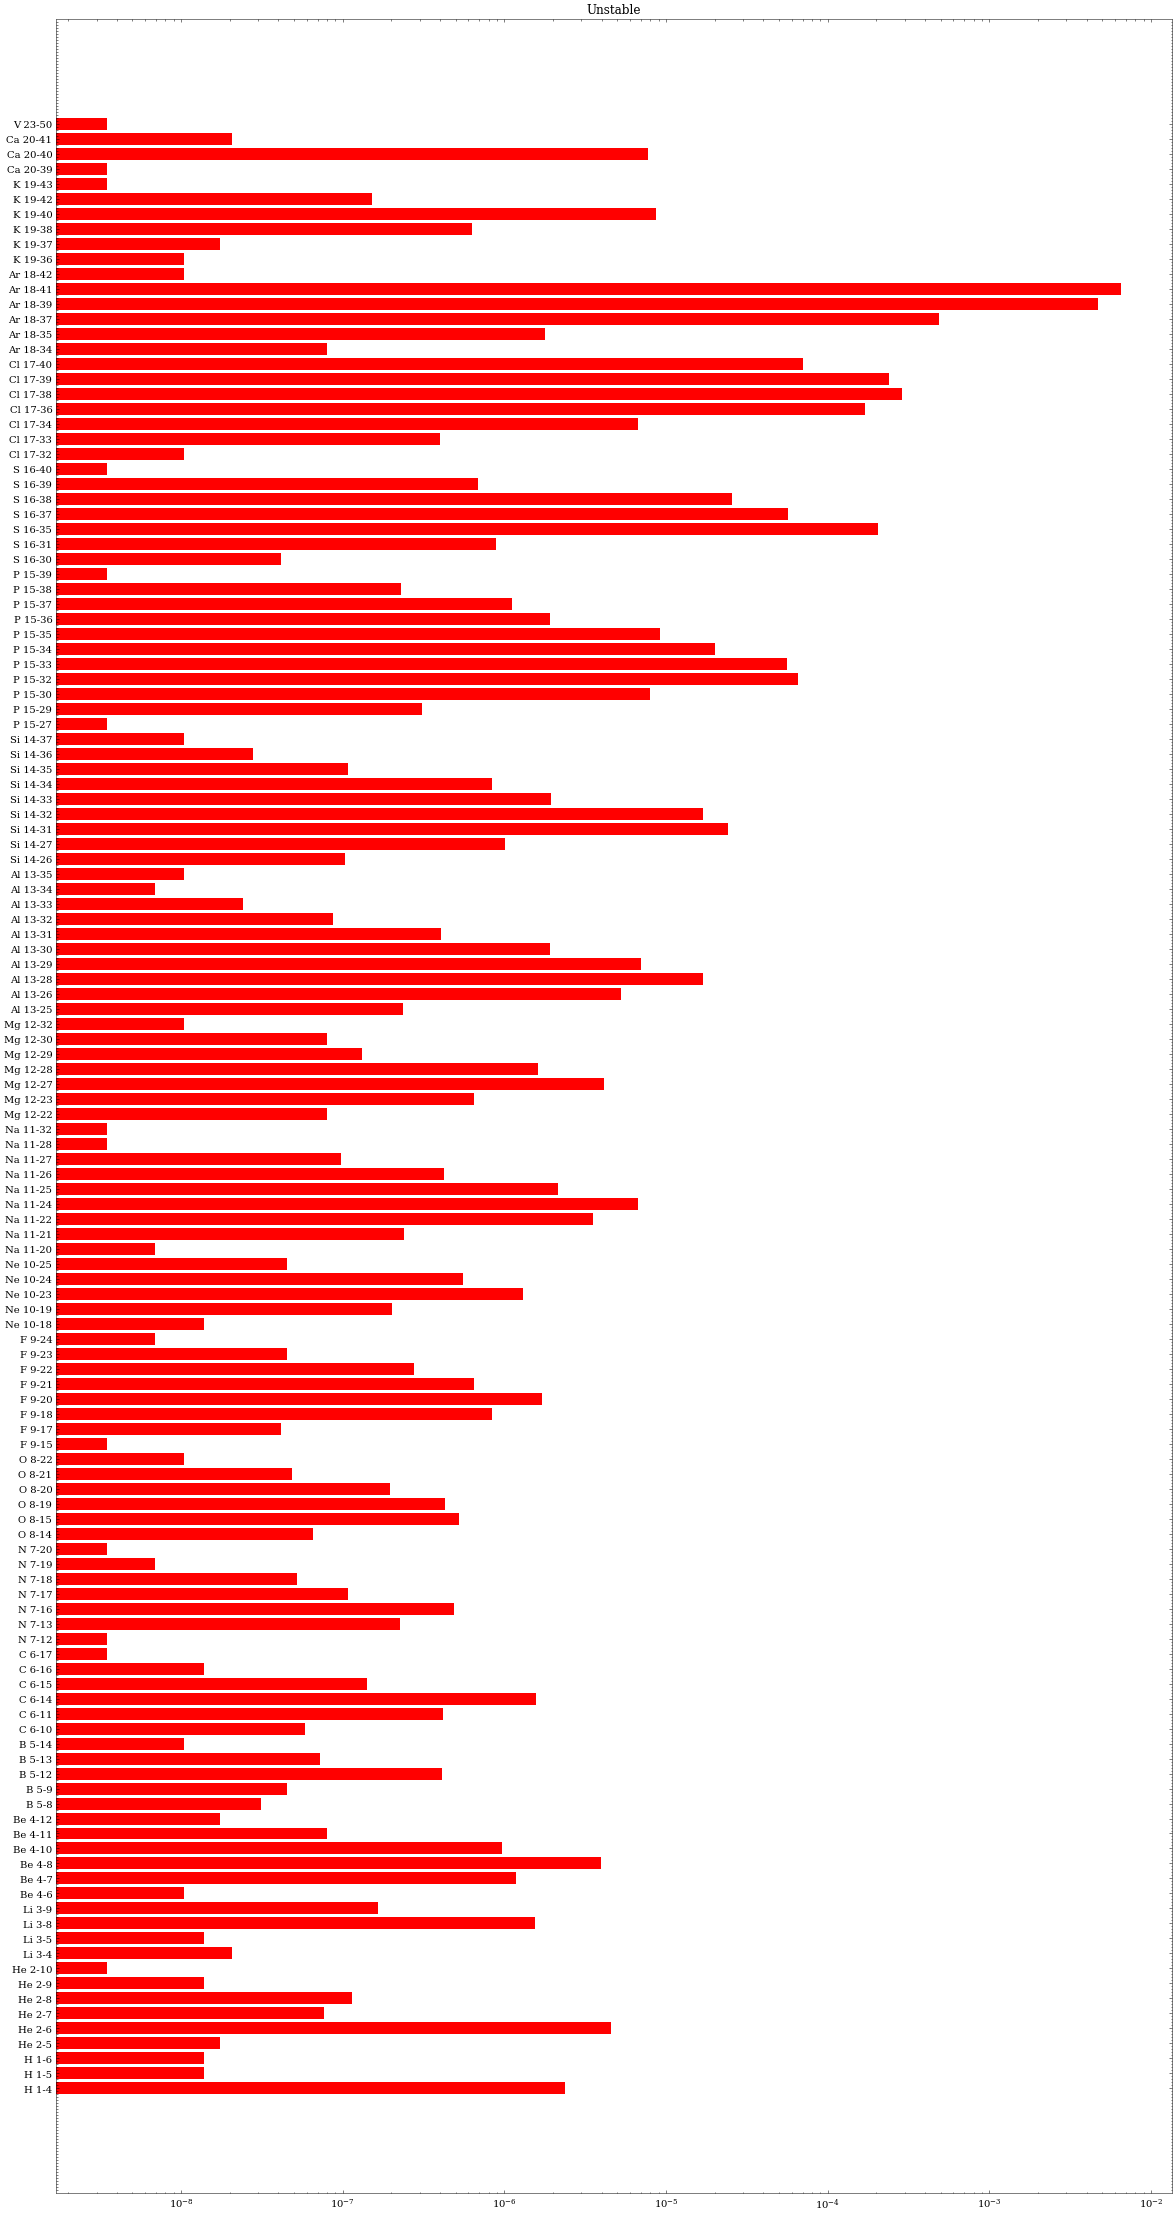

In [58]:
fig_un, ax_un = plt.subplots(figsize=figsize)
df_unstable_TPC = df_unstable[df_unstable["Detector Volume"] == 11].reset_index(drop=True)
ax_un.barh(df_unstable_TPC.index, df_unstable_TPC["Production Yield"], log=True, color=df_unstable_TPC["Plot Colour"])
ax_un.set_yticklabels(df_unstable_TPC["Iso Symbol"])
ax_un.set_yticks(np.arange(len(df_unstable_TPC)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_un.set_title("Unstable")
plt.show()

# Plot stable

Text(0.5, 1.0, 'Stable')

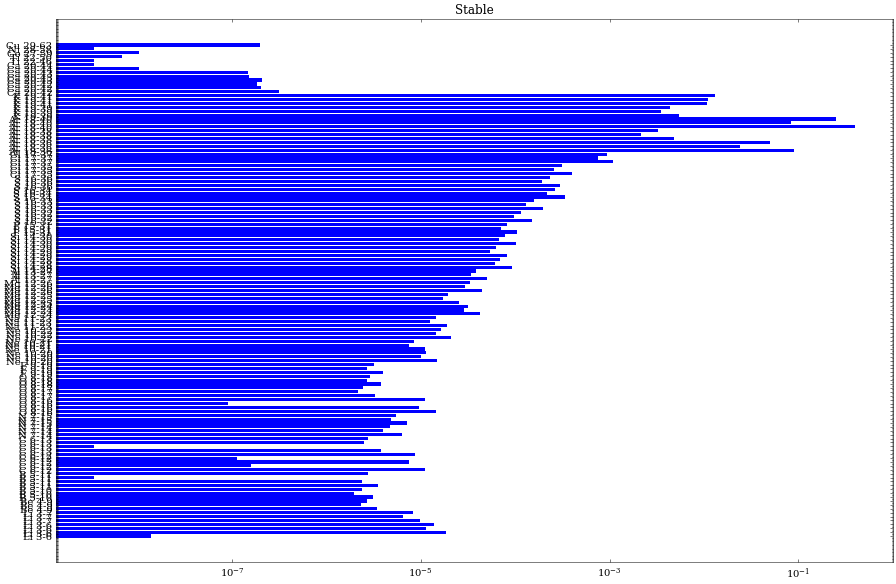

In [59]:
fig_s, ax_s = plt.subplots(figsize=(15,10))
ax_s.barh(df_stable.index, df_stable["Production Yield"], log=True, color=df_stable["Plot Colour"])
ax_s.set_yticklabels(df_stable["Iso Symbol"])
ax_s.set_yticks(np.arange(len(df_stable)))
ax.set_xlabel("Production Yield")
ax.set_ylabel("Isotope")
ax_s.set_title("Stable")
#plt.show()

# Ratio of counts in each volume
key: 7, 9, 11

val: Outer, Inner, TPC

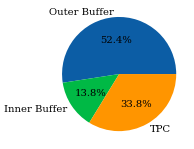

In [60]:
df_OB = df[df["Detector Volume"] == 7]
df_IB = df[df["Detector Volume"] == 9]
df_TPC = df[df["Detector Volume"] == 11]
plt.pie(x=[df_OB["Counts"].sum(), df_IB["Counts"].sum(), df_TPC["Counts"].sum()], autopct='%1.1f%%', labels=["Outer Buffer", "Inner Buffer", "TPC"])
#plt.savefig('./img/volume-ratio.png', dpi=DPI)
plt.show()

In [61]:
# Ratio of stable to unstable
print(f'{df_stable["Counts"].sum() / df_unstable["Counts"].sum()}')

25.66553931837183


# Looking for excess yields

In [62]:
# Sort df by counts
df_count_sort = df.sort_values(["Counts"], ascending=False)
# Try to highlight mass numbers > 40
# df_count_sort.style.apply(lambda x: ["background-color: red" if x["Mass Number"] > 40 else ""], axis = 1)
# Total df
df_count_sort.head(60)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
484,Ar 18-40,18,40,114812624,7,0.397454,True,inf,None,NaN,blue,3.95769e+06,1
486,Ar 18-40,18,40,72671117,11,0.251570,True,inf,None,NaN,blue,2.50504e+06,0.632954
424,Ar 18-36,18,36,25740652,7,0.089108,True,inf,None,NaN,blue,887303,0.224197
485,Ar 18-40,18,40,24283053,9,0.084062,True,inf,None,NaN,blue,837058,0.211502
426,Ar 18-36,18,36,14367768,11,0.049738,True,inf,None,NaN,blue,495269,0.125141
425,Ar 18-36,18,36,6978210,9,0.024157,True,inf,None,NaN,blue,240545,0.0607791
498,K 19-41,19,41,3765195,11,0.013034,True,inf,None,NaN,blue,129790,0.0327943
497,K 19-41,19,41,3205525,9,0.011097,True,inf,None,NaN,blue,110497,0.0279196
496,K 19-41,19,41,3138162,7,0.010864,True,inf,None,NaN,blue,108175,0.0273329
495,Ar 18-41,18,41,1889720,11,0.006542,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,65140.3,0.0164592


### Unstable (Counts)
To get a sense of most produced isotopes

In [63]:
# Unstable df sorted by counts
df_count_sort[df_count_sort["Stable"] == False].head(60)

,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
495,Ar 18-41,18,41,1889720,11,0.006542,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,65140.3,0.0164592
470,Ar 18-39,18,39,1693260,7,0.005862,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,58368.1,0.014748
494,Ar 18-41,18,41,1608814,9,0.005569,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,55457.2,0.0140125
493,Ar 18-41,18,41,1574956,7,0.005452,False,6.580000e+03,"[[B-, 1.0, 2.492]]",2.492,red,54290.1,0.0137176
472,Ar 18-39,18,39,1357198,11,0.004698,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,46783.8,0.011821
471,Ar 18-39,18,39,1084730,9,0.003755,False,8.490000e+09,"[[B-, 1.0, 0.565]]",0.565,red,37391.6,0.00944782
441,Ar 18-37,18,37,154388,7,0.000534,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,5321.89,0.00134469
443,Ar 18-37,18,37,140584,11,0.000487,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,4846.05,0.00122446
442,Ar 18-37,18,37,115268,9,0.000399,False,3.030000e+06,"[[EC, 1.0, 0.814]]",0.814,red,3973.39,0.00100396
453,Cl 17-38,17,38,104167,7,0.000361,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,3590.73,0.00090727


### Unstable all (heavy (40>))
Any heavy isotopes that may decay

In [74]:
df_unstable.sort_values(["Atomic Number", "Mass Number"], ascending=False).head(50)

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
398,522,V 23-50,23,50,1,11,3.461762e-09,False,6.630000e+24,"[[EC, 0.929, 1.038], [B-, 0.071, 1.038]]",1.038,red,0.0344709,0
397,519,Sc 21-44,21,44,1,7,3.461762e-09,False,1.430000e+04,"[[EC, 1.0, 3.652]]",3.652,red,0.0344709,0
394,499,Ca 20-41,20,41,9,7,3.115586e-08,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.310238,6.96787e-08
395,500,Ca 20-41,20,41,1,9,3.461762e-09,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.0344709,0
396,501,Ca 20-41,20,41,6,11,2.077057e-08,False,3.220000e+12,"[[EC, 1.0, 0.421]]",0.421,red,0.206825,4.35492e-08
391,490,Ca 20-40,20,40,3035,7,1.050645e-05,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,104.619,2.64257e-05
392,491,Ca 20-40,20,40,1965,9,6.802363e-06,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,67.7353,1.71061e-05
393,492,Ca 20-40,20,40,2226,11,7.705883e-06,False,9.470000e+28,"[[2EC, None, 0.0]]",NaN,red,76.7322,1.93794e-05
388,476,Ca 20-39,20,39,1,7,3.461762e-09,False,8.600000e-01,"[[EC, 1.0, 6.533]]",6.533,red,0.0344709,0
389,477,Ca 20-39,20,39,1,9,3.461762e-09,False,8.600000e-01,"[[EC, 1.0, 6.533]]",6.533,red,0.0344709,0


### Unstable all (Half-life)

In [65]:
df_unstable_sort_life = df_unstable.sort_values("Half Life (ns)", ascending=True)
df_unstable_sort_life.head(60)

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
0,0,H 1-4,1,4,912,7,3.157127e-06,False,0.000000e+00,"[[N, 1.0, 2.88]]",2.880,red,31.4374,7.93467e-06
39,64,Li 3-10,3,10,2,9,6.923524e-09,False,0.000000e+00,"[[N, 1.0, 0.025]]",0.025,red,0.0689417,8.70984e-09
38,63,Li 3-10,3,10,7,7,2.423234e-08,False,0.000000e+00,"[[N, 1.0, 0.025]]",0.025,red,0.241296,5.22591e-08
22,50,He 2-9,2,9,1,9,3.461762e-09,False,0.000000e+00,"[[N, 1.0, 1.27]]",1.270,red,0.0344709,0
21,49,He 2-9,2,9,2,7,6.923524e-09,False,0.000000e+00,"[[N, 1.0, 1.27]]",1.270,red,0.0689417,8.70984e-09
23,51,He 2-9,2,9,4,11,1.384705e-08,False,0.000000e+00,"[[N, 1.0, 1.27]]",1.270,red,0.137883,2.61295e-08
1,1,H 1-4,1,4,582,9,2.014746e-06,False,0.000000e+00,"[[N, 1.0, 2.88]]",2.880,red,20.062,5.06042e-06
2,2,H 1-4,1,4,690,11,2.388616e-06,False,0.000000e+00,"[[N, 1.0, 2.88]]",2.880,red,23.7849,6.00108e-06
26,3,Li 3-4,3,4,12,7,4.154115e-08,False,7.870000e-23,"[[P, 1.0, 3.103]]",3.103,red,0.41365,9.58083e-08
28,5,Li 3-4,3,4,6,11,2.077057e-08,False,7.870000e-23,"[[P, 1.0, 3.103]]",3.103,red,0.206825,4.35492e-08


# Looking at production yields

### Unstable (Production yield > 0.1%)

In [66]:
# Sets min production yield to be 1%
high_prod_yield = df_unstable[(df_unstable["Production Yield"] > 0.0001)]
high_prod_yield

,index,Iso Symbol,Atomic Number,Mass Number,Counts,Detector Volume,Production Yield,Stable,Half Life (ns),"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour,Production (/yr),Count per Muon
314,403,S 16-35,16,35,74961,7,0.000259,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,2583.97,0.00065289
315,404,S 16-35,16,35,48584,9,0.000168,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,1674.73,0.00042315
316,405,S 16-35,16,35,58958,11,0.000204,False,7.550000e+06,"[[B-, 1.0, 0.167]]",0.167,red,2032.33,0.000513506
338,421,Cl 17-36,17,36,61753,7,0.000214,False,9.500000e+12,"[[B-, 0.981, 0.71], [EC, 0.019, 0.71]]",0.710,red,2128.68,0.00053785
339,422,Cl 17-36,17,36,39597,9,0.000137,False,9.500000e+12,"[[B-, 0.981, 0.71], [EC, 0.019, 0.71]]",0.710,red,1364.94,0.000344875
340,423,Cl 17-36,17,36,49233,11,0.000170,False,9.500000e+12,"[[B-, 0.981, 0.71], [EC, 0.019, 0.71]]",0.710,red,1697.1,0.000428803
341,453,Cl 17-38,17,38,104167,7,0.000361,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,3590.73,0.00090727
342,454,Cl 17-38,17,38,67761,9,0.000235,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,2335.78,0.000590179
343,455,Cl 17-38,17,38,82767,11,0.000287,False,2.230000e+03,"[[B-, 1.0, 4.916]]",4.916,red,2853.05,0.000720879
344,467,Cl 17-39,17,39,85938,7,0.000297,False,3.370000e+03,"[[B-, 1.0, 3.442]]",3.442,red,2962.36,0.000748498
